In [1]:
import sys
sys.path.insert(0, "../lib")

In [2]:
import math
import os
import pathlib
import re

import scanpy as sc
import numpy as np
import pandas as pd
import sc_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler
import scipy
import statsmodels.stats.multitest

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
FONT_DIR = '/projects/b1038/Pulmonary/nmarkov/fonts'
for f in os.listdir(FONT_DIR):
    if f.endswith('.ttf'):
        mpl.font_manager.fontManager.addfont(f'{FONT_DIR}/{f}')

In [5]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42
# mpl.rcParams['mathtext.default'] = 'regular'


In [6]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        if pd.api.types.is_numeric_dtype(df[column]):
            values = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
            if not isinstance(palette, mpl.colors.Colormap):
                palette = sns.color_palette(palette, as_cmap=True)
            colors = palette(values)
            colors = [mpl.colors.to_hex(color) for color in colors]
            colors = pd.Series(colors, index=values.index, name=column)
        else:
            lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
            colors = df[column].map(lut)
        result.append(colors)
    return pd.concat(result, axis=1)

In [7]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [8]:
adata = sc.read_h5ad(DATA / '03_bal-object/03_bal-object.h5ad')

In [9]:
adata.obs.cell_type = adata.obs.cell_type.astype(str).replace({
    'MoAM-3 mature': 'MoAM-2',
    'MoAM-4 profibrotic': 'MoAM-3 profibrotic',
    'gd/NKT cells': 'NK + γδT cells',
    'Perivascular macrophages': 'Interstitial macrophages',
}).astype('category')

In [ ]:
adata.obs.Status = pd.Categorical(adata.obs.Status.astype(str).replace({
    'control': 'Control',
    'SSc': 'SSc-ILD'
}), categories=['Control', 'SSc-ILD'])

In [11]:
rng = np.random.default_rng(seed=101)
adata.uns['cell_type_colors'] = list(rng.permutation(
    adata.uns['cell_type_colors']
))

# 1. Plot IFNG response scores pseudobulks

In [12]:
msigdb = decoupler.get_resource('MSigDB', organism='human')

In [13]:
hallmark = msigdb[msigdb.collection.eq('hallmark')]

In [14]:
hallmark = hallmark[~hallmark.duplicated(['geneset', 'genesymbol'])]

In [15]:
IFNG_RESP_LIST = hallmark.genesymbol[hallmark.geneset.eq('HALLMARK_INTERFERON_GAMMA_RESPONSE')]

In [16]:
sc.tl.score_genes(
    adata,
    gene_list=IFNG_RESP_LIST,
    ctrl_size=len(IFNG_RESP_LIST),
    score_name='Interferon gamma response score',
    use_raw=True
)

Now pseudobulk

In [ ]:
THRESHOLD = 25
pseudobulk = []
meta = []
for sample in adata.obs['External Sample ID'].unique():
    for ct in adata.obs.cell_type.unique():
        idx = adata.obs['External Sample ID'].eq(sample) & adata.obs.cell_type.eq(ct)
        if idx.sum() < THRESHOLD:
            continue
        pseudobulk.append(adata.obs['Interferon gamma response score'][idx].mean())
        meta.append((sample, ct))
pseudobulk = pd.DataFrame(
    pseudobulk,
    columns=['Interferon gamma response score']
)
meta = pd.DataFrame(meta, columns=('sample', 'cell_type'))

In [18]:
df = pd.concat([meta, pseudobulk], axis=1)
df['condition'] = (
    adata.obs.groupby('External Sample ID').head(1).set_index('External Sample ID').Status[
        df['sample'].values
    ].values
)
df.condition = pd.Categorical(df.condition, categories=['Control', 'SSc-ILD'])

In [19]:
# Cell types that have significant GSEA for IFNG response
# Plus manual curation
CELL_TYPES = [
    'Monocytes',
    'MoAM-1',
    'MoAM-2',
    'MoAM-3 profibrotic',
    'TRAM-2',
    'TRAM-6 activated',
    'Interstitial macrophages',
    # 'Proliferating macrophages',
    'DC2',
]

In [20]:
df = df.loc[df.cell_type.isin(CELL_TYPES)]
df.cell_type = pd.Categorical(df.cell_type, categories=CELL_TYPES)

In [21]:
stat_results = []
for ct in df.cell_type.unique():
    ctrl = df['Interferon gamma response score'][df.cell_type.eq(ct) & df.condition.eq('Control')]
    ssc = df['Interferon gamma response score'][df.cell_type.eq(ct) & df.condition.eq('SSc-ILD')]
    if ctrl.size == 0 or ssc.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(ctrl, ssc).pvalue
    stat_results.append(["cell_type", ct, "Control", "SSc-ILD", ctrl.size, ssc.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])

stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "cell_type":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))
pairs

[]

In [22]:
stat_results

,variable,value,group1,group2,group1_size,group2_size,pval,pval_adj
0,cell_type,DC2,Control,SSc-ILD,9,10,0.595611,0.680698
1,cell_type,TRAM-2,Control,SSc-ILD,13,10,0.203602,0.411334
2,cell_type,MoAM-2,Control,SSc-ILD,13,10,0.162898,0.411334
3,cell_type,TRAM-6 activated,Control,SSc-ILD,13,10,0.686865,0.686865
4,cell_type,MoAM-3 profibrotic,Control,SSc-ILD,8,10,0.514786,0.680698
5,cell_type,Monocytes,Control,SSc-ILD,8,10,0.408245,0.653193
6,cell_type,Interstitial macrophages,Control,SSc-ILD,9,10,0.205667,0.411334
7,cell_type,MoAM-1,Control,SSc-ILD,5,10,0.027972,0.223776


No significant differences using Mann-Whitney with FDR

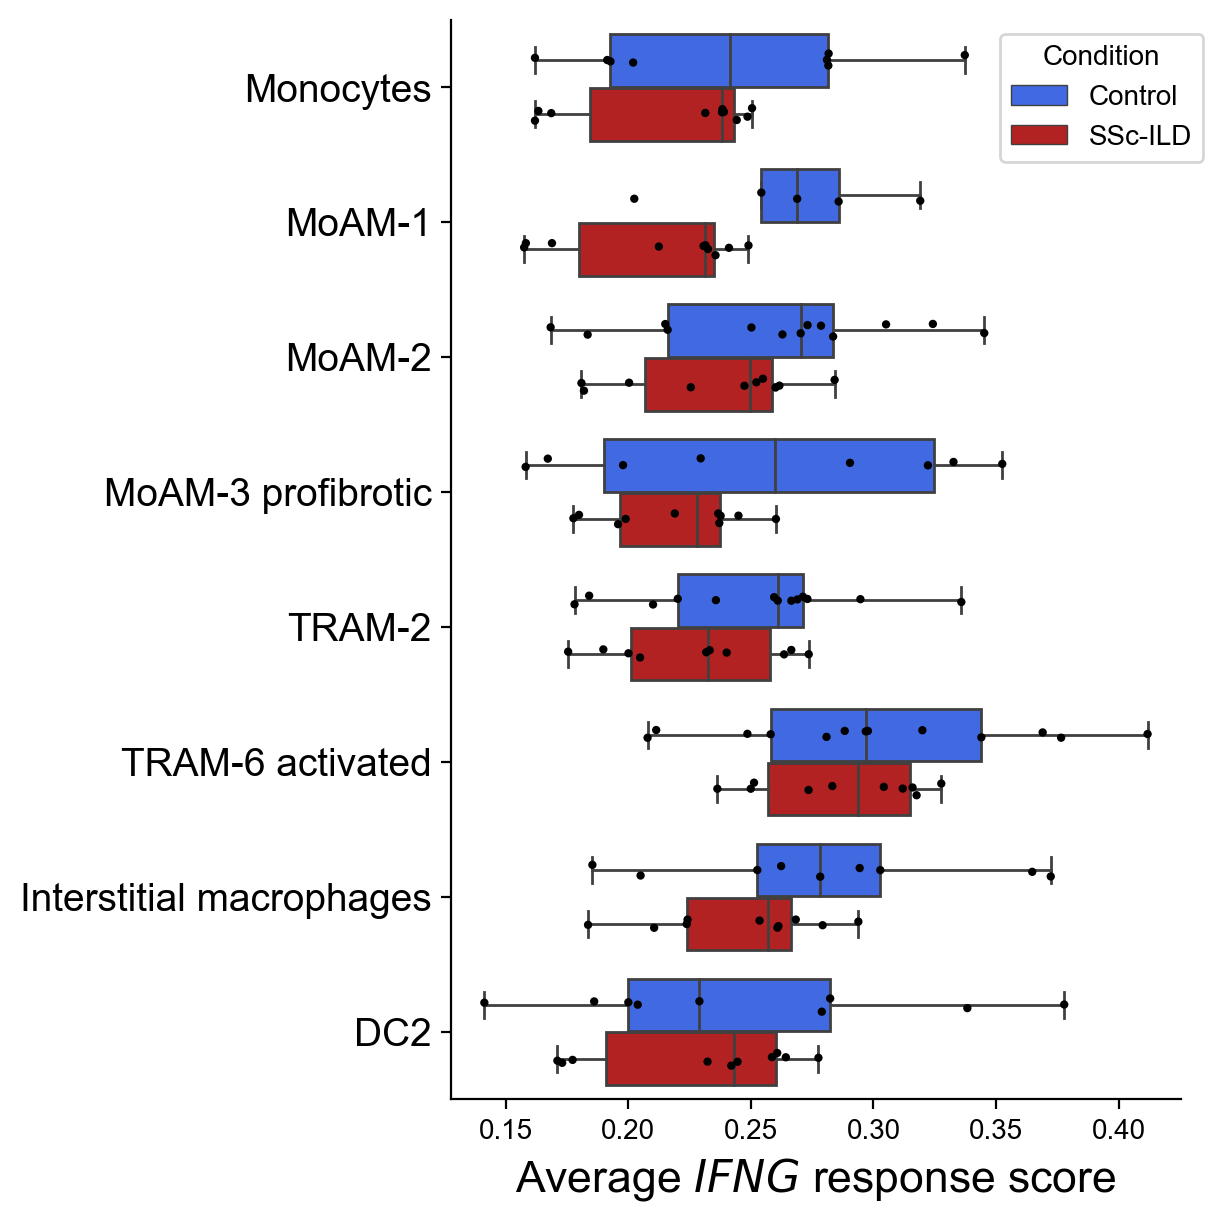

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)

sns.boxplot(
    data=df,
    y='cell_type',
    x='Interferon gamma response score',
    hue='condition',
    palette=['royalblue', 'firebrick'],
    ax=ax,
    showfliers=False,
    saturation=1,
    linewidth=1,
)
sns.stripplot(
    data=df,
    y='cell_type',
    x='Interferon gamma response score',
    hue='condition',
    dodge=True,
    ax=ax,
    size=3,
    palette=['k', 'k'],
    legend=False,
)

# # start_height = counts[pc].max()
# incrementer = 20 # px
# labels = [x.get_text() for x in ax.get_yticklabels()]
# q = ax.transData.inverted().transform([[0, 0], [incrementer, 0]])
# x_offset = q[1][0] - q[0][0]
# gap = x_offset / 2
# # y = start_height
# for _, r in stat_results_sign.iterrows():
#     p = f'$q={r.pval_adj:.3f}$'
#     y = labels.index(str(r.value))
#     x = counts.percent_in_sample[counts.cell_type_level_3.eq(r.value)].max()

#     col = 'k'
#     h = gap / 2
#     x += gap
#     o = 0.3

#     bracket = ax.plot([x, x+h, x+h, x], [y-o, y-o, y+o, y+o], lw=1, c=col)
#     txt = ax.text(x+2*h, y, p, ha='left', va='center', color=col, size=8)

ax.set_xlabel('Average $IFNG$ response score', size=16)
ax.set_ylabel('')
ax.tick_params(axis='y', labelsize=14)
ax.spines[['top', 'right']].set_visible(False)
h, l = ax.get_legend_handles_labels()
ax.legend(
    handles=h,
    labels=l,
    title='Condition',
    bbox_to_anchor=(1.05, 1),
    # fontsize=12,
    # title_fontsize=12
)
fig.savefig('00_figures/Figure_2D_avg_IFNG_resp_score.pdf')

# 2. Plot IFNG response scores pseudobulks by active therapy

In [66]:
CLINICAL = pd.read_csv('../00clinical-v2.csv')
SAMPLES = pd.read_csv('../00all-samples.csv')

In [67]:
SAMPLES['study_code'] = SAMPLES.Sample.str.replace('_followup', '')

In [ ]:
sample_data = CLINICAL.merge(
    SAMPLES[['study_code', 'External Sample ID']],
    on='study_code',
    how='left'
)

In [69]:
df['active_therapy'] = sample_data.set_index('External Sample ID').patient_on_mmf[
    df['sample'].values
].values

In [70]:
df = df.dropna(subset='active_therapy')

In [71]:
stat_results = []
for ct in df.cell_type.unique():
    myco = df['Interferon gamma response score'][df.cell_type.eq(ct) & df.active_therapy.eq(True)]
    no_myco = df['Interferon gamma response score'][df.cell_type.eq(ct) & df.active_therapy.eq(False)]
    if myco.size == 0 or no_myco.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(myco, no_myco).pvalue
    stat_results.append(["cell_type", ct, "Myco", "No Myco", myco.size, no_myco.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])

stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "cell_type":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))
pairs

[]

In [72]:
stat_results

,variable,value,group1,group2,group1_size,group2_size,pval,pval_adj
0,cell_type,DC2,Myco,No Myco,4,6,0.761905,0.870748
1,cell_type,TRAM-2,Myco,No Myco,4,6,0.066667,0.533333
2,cell_type,MoAM-2 mature,Myco,No Myco,4,6,0.476190,0.870748
3,cell_type,TRAM-6 activated,Myco,No Myco,4,6,0.761905,0.870748
4,cell_type,MoAM-3 profibrotic,Myco,No Myco,4,6,0.761905,0.870748
5,cell_type,Monocytes,Myco,No Myco,4,6,0.352381,0.870748
6,cell_type,Interstitial macrophages,Myco,No Myco,4,6,0.914286,0.914286
7,cell_type,MoAM-1,Myco,No Myco,4,6,0.609524,0.870748


No significant differences using Mann-Whitney with FDR

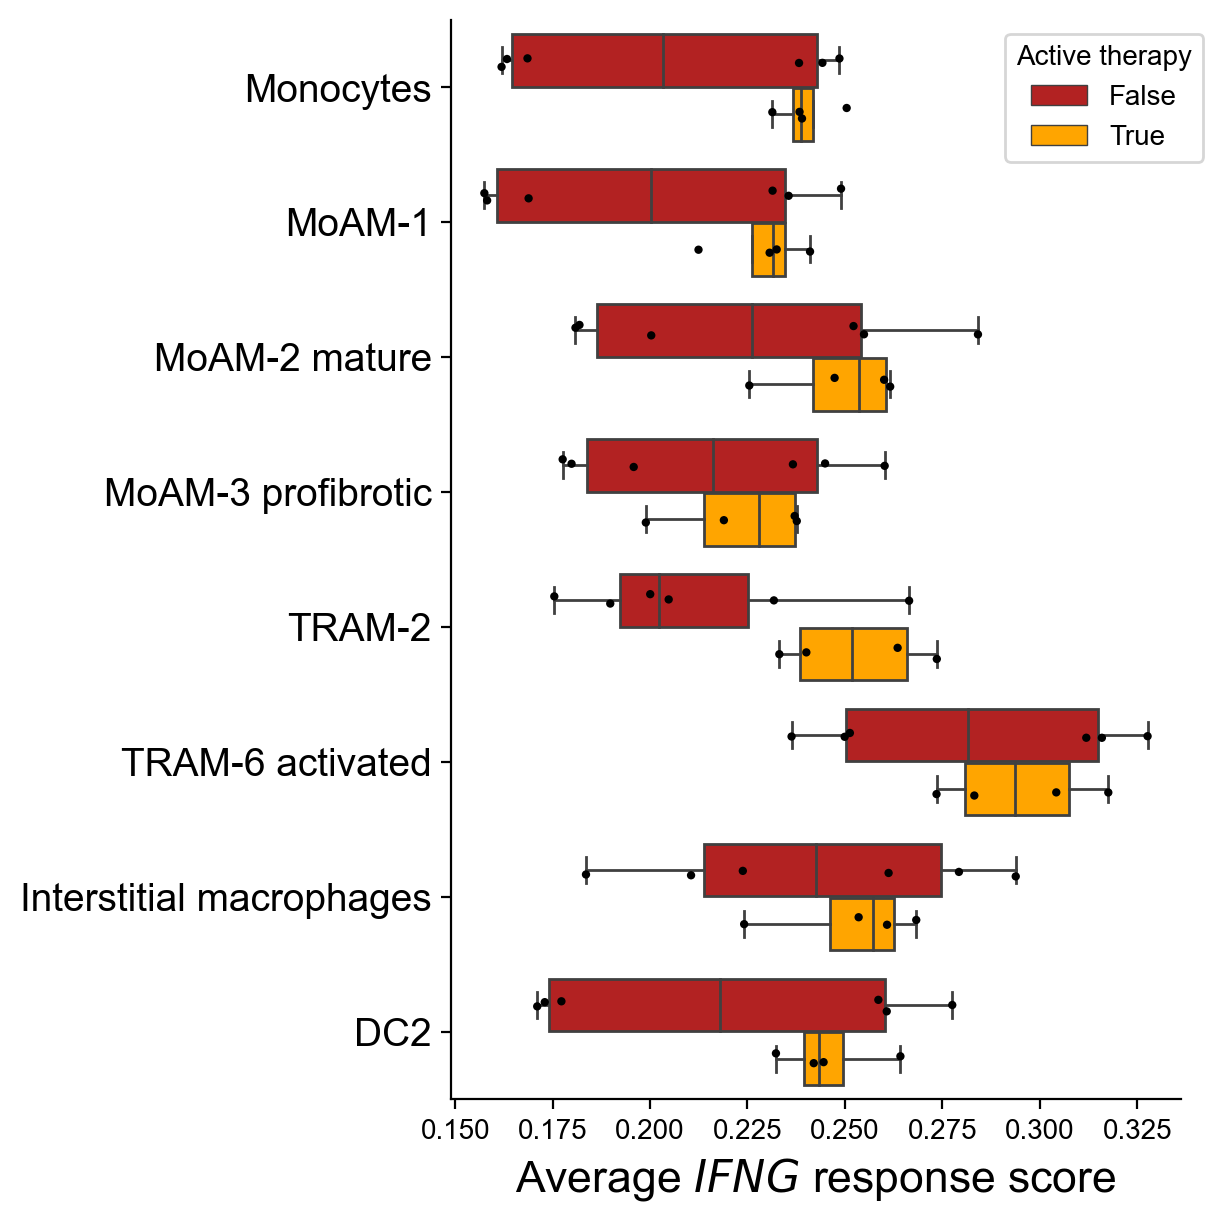

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)

sns.boxplot(
    data=df,
    y='cell_type',
    x='Interferon gamma response score',
    hue='active_therapy',
    palette=['firebrick', 'orange'],
    ax=ax,
    showfliers=False,
    saturation=1,
    linewidth=1
)
sns.stripplot(
    data=df,
    y='cell_type',
    x='Interferon gamma response score',
    hue='active_therapy',
    dodge=True,
    ax=ax,
    size=3,
    palette=['k', 'k'],
    legend=False
)

# # start_height = counts[pc].max()
# incrementer = 20 # px
# labels = [x.get_text() for x in ax.get_yticklabels()]
# q = ax.transData.inverted().transform([[0, 0], [incrementer, 0]])
# x_offset = q[1][0] - q[0][0]
# gap = x_offset / 2
# # y = start_height
# for _, r in stat_results_sign.iterrows():
#     p = f'$q={r.pval_adj:.3f}$'
#     y = labels.index(str(r.value))
#     x = counts.percent_in_sample[counts.cell_type_level_3.eq(r.value)].max()

#     col = 'k'
#     h = gap / 2
#     x += gap
#     o = 0.3

#     bracket = ax.plot([x, x+h, x+h, x], [y-o, y-o, y+o, y+o], lw=1, c=col)
#     txt = ax.text(x+2*h, y, p, ha='left', va='center', color=col, size=8)

ax.set_xlabel('Average $IFNG$ response score', size=16)
ax.set_ylabel('')
ax.tick_params(axis='y', labelsize=14)
ax.spines[['top', 'right']].set_visible(False)
h, l = ax.get_legend_handles_labels()
ax.legend(
    handles=h,
    labels=l,
    title='Active therapy',
    bbox_to_anchor=(1.05, 1),
    # fontsize=12,
    # title_fontsize=12
)
# fig.savefig('00_figures/Figure_3D_avg_IFNG_resp_score.pdf')

There is a bimodal distribution for patients not on active therapy.

In [79]:
df.loc[df.active_therapy.eq(False)].sort_values(['cell_type', 'Interferon gamma response score'])

,sample,cell_type,Interferon gamma response score,condition,active_therapy
140,SSc_SSc7,Monocytes,0.161895,SSc-ILD,False
77,SSc_SSc4,Monocytes,0.163285,SSc-ILD,False
117,SSc_SSc6,Monocytes,0.168548,SSc-ILD,False
184,SSc_SSc9,Monocytes,0.238225,SSc-ILD,False
164,SSc_SSc8,Monocytes,0.244226,SSc-ILD,False
206,SSc_SSc10,Monocytes,0.248594,SSc-ILD,False
83,SSc_SSc4,MoAM-1,0.157481,SSc-ILD,False
146,SSc_SSc7,MoAM-1,0.158191,SSc-ILD,False
123,SSc_SSc6,MoAM-1,0.168836,SSc-ILD,False
189,SSc_SSc9,MoAM-1,0.231438,SSc-ILD,False


The lowest-scoring 3 samples for each cell type are the same: SSc4, 6, 7

In [ ]:
SAMPLES.loc[SAMPLES['External Sample ID'].isin([
    'SSc_SSc4',
    'SSc_SSc6',
    'SSc_SSc7',
])]

Compared to the highest-scoring 3 samples

In [ ]:
SAMPLES.loc[SAMPLES['External Sample ID'].isin([
    'SSc_SSc8',
    'SSc_SSc9',
    'SSc_SSc10',
])]

`SSc_SSc8` is a follow-up of `SSc_SSc6`

## Conclusions

- _IFNG_ response scores are not different between patient on active therapy and off therapy
- patients off therapy show high variance in _IFNG_ response scores
- same 3 samples are consistently lower in _IFNG_ response scores across many datasets
- this is despite _IFNG_ levels itself being lower in patients on active therapy
- I suppose the pathway has many genes and the effect is different for different genes of the pathway